In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt
from cleaning_function import *

tf.config.threading.set_intra_op_parallelism_threads(64)
tf.config.threading.set_inter_op_parallelism_threads(64)

# Load the data
X = pd.read_csv('california_predict.csv')
X = exclude_columns(X, ['black', 'NHPI','asian','white','hispanic'])
y = pd.read_csv('california_response.csv')

# Replace missing values in y with NaN
y = y.replace("?", np.nan)  # If missing values are marked with "?" in the dataset
y_numeric = y.select_dtypes(include="number")  # Remove 'statecounty'

# Normalize X (remove the 'statecounty' column)
X_numeric = X.select_dtypes(include='number')  # Remove 'statecounty'
X_numeric.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_numeric, test_size=0.2)

In [23]:
#y_train = y_train.fillna(y_train.mean())

In [24]:
X

,Healthcare_General_Practice_Provider_Rate_per100000_HRSA2020,Healthcare_Family_Medicine_Provider_Rate_per100000_HRSA2020,Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20,Population_With_Health_Insurance_ACS2016_20,Population_Without_Health_Insurance_ACS2016_20,Percent_Population_Without_Health_Insurance_ACS2016_20,Population_18yrs_And_Under_Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20,Population_18yrs_And_Under_With_Health_Insurance_ACS2016_20,Population_18yrs_And_Under_Without_Health_Insurance_ACS2016_20,PercentPopulation_18yrs_And_Under_Without_Health_Insurance_ACS2016_20,...,Percent_of_Farmers_Market_Accept_SNAP_USDA_2018,Number_of_Farmers_Market_Accept_WIC_USDA_2018,Percent_of_Farmers_Market_Accept_WIC_USDA_2018,Number_of_Farmers_Market_Accept_WIC_Cash_USDA_2018,Percent_of_Farmers_Market_Accept_SNAP_USDA_2018.1,Number_of_Farmers_Market_Accept_SFMNP_USDA_2018,Percent_of_Farmers_Market_Accept_SFMNP_USDA_2018,Number_of_Recreation_Fitness_Facilities_Per1000_Residents_USDA_2016,statecounty,state_number
0,0.894737,0.197761,29.279222,30.535021,14.082571,-0.666137,26.484763,26.895621,10.351053,-0.509273,...,2.117647,27.0,4.563380,9.0,2.117647,25.0,2.205882,25.666667,06Alameda County,6
1,0.000000,-1.044776,-0.430581,-0.423881,-0.447683,-0.136725,-0.429243,-0.415777,-0.418589,-0.322807,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,-0.333333,06Alpine County,6
2,5.263158,-0.391791,0.186679,0.214075,-0.090322,-0.529412,0.012309,0.027132,-0.152457,-0.286717,...,0.000000,4.0,5.746479,0.0,0.000000,4.0,3.000000,0.333333,06Amador County,6
3,1.000000,0.130597,3.521559,3.618124,2.290498,-0.383148,3.176952,3.240733,1.075226,-0.493233,...,1.500000,5.0,3.591549,2.0,1.500000,4.0,1.500000,3.333333,06Butte County,6
4,1.157895,-0.320896,0.365701,0.397033,0.035137,-0.494436,0.148932,0.180969,-0.361083,-0.828070,...,0.000000,1.0,1.915493,0.0,0.000000,2.0,2.000000,0.333333,06Calaveras County,6
5,0.000000,-0.179104,-0.067426,-0.062448,-0.090735,0.007949,0.014168,0.033616,-0.231361,-0.479198,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,06Colusa County,6
6,1.000000,0.432836,20.110841,20.815920,11.342738,-0.548490,19.932432,20.135119,9.659646,-0.405013,...,2.160000,19.0,4.367324,1.0,2.160000,6.0,0.720000,23.000000,06Contra Costa County,6
7,0.000000,0.421642,-0.002420,0.017017,-0.182711,-0.470588,0.025547,0.033153,-0.018723,0.010025,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,-0.333333,06Del Norte County,6
8,0.526316,0.522388,2.950413,3.097584,1.223583,-0.656598,2.531172,2.570734,1.071214,-0.394987,...,2.400000,8.0,4.597183,2.0,2.400000,8.0,2.400000,4.166667,06El Dorado County,6
9,0.684211,0.018657,17.155561,17.224077,15.304707,-0.103339,21.530037,21.710851,11.086593,-0.372932,...,0.400000,1.0,0.383099,2.0,0.400000,2.0,0.400000,10.000000,06Fresno County,6


In [25]:
print(X_train.isnull().sum())
print(X_train.isin([np.inf, -np.inf]).sum())
print(y_train.isnull().sum())


Healthcare_General_Practice_Provider_Rate_per100000_HRSA2020                  0
Healthcare_Family_Medicine_Provider_Rate_per100000_HRSA2020                   0
Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20    0
Population_With_Health_Insurance_ACS2016_20                                   0
Population_Without_Health_Insurance_ACS2016_20                                0
                                                                             ..
Percent_of_Farmers_Market_Accept_SNAP_USDA_2018.1                             0
Number_of_Farmers_Market_Accept_SFMNP_USDA_2018                               0
Percent_of_Farmers_Market_Accept_SFMNP_USDA_2018                              0
Number_of_Recreation_Fitness_Facilities_Per1000_Residents_USDA_2016           0
state_number                                                                  0
Length: 214, dtype: int64
Healthcare_General_Practice_Provider_Rate_per100000_HRSA2020                  0
Healthcare_Fam

In [26]:
def masked_loss(y_true, y_pred):
    mask = tf.math.is_finite(y_true)  # Create a mask to ignore NaNs
    diff = tf.boolean_mask(y_true - y_pred, mask)  # Ignore NaNs
    return tf.reduce_mean(tf.square(diff))

def build_model(hp):
    model = tf.keras.models.Sequential()
    input_dim = X_train.shape[1]  # Ensure correct input dimension
    model.add(tf.keras.layers.InputLayer(input_shape=(input_dim,)))

    # Tune number of layers and units
    for i in range(hp.Int('num_layers', 2, 3)):  # Between 2 and 3 layers
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                     min_value=128,
                                                     max_value=256,  # Adjust range
                                                     step=64),
                                        activation='relu'))
        model.add(tf.keras.layers.Dropout(hp.Float('dropout_' + str(i),
                                                   min_value=0.2,
                                                   max_value=0.4,
                                                   step=0.1)))

    # Output layer matching y_train shape
    output_dim = y_train.shape[1] if len(y_train.shape) > 1 else 1
    model.add(tf.keras.layers.Dense(output_dim, activation='linear'))

    # Compile model with masked loss
    model.compile(optimizer=tf.keras.optimizers.Adam(
                      hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')),
                  loss=masked_loss,
                  metrics=['mae'])
    return model

# Hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='multi_target_hyperparam_tuning',
    max_consecutive_failed_trials=10
)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [27]:
# tuner.results_summary()


In [28]:

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=64, verbose = 1)

best_model = tuner.get_best_models(num_models=1)[0]
loss, mae = best_model.evaluate(X_test, y_test)
print(f"Best Model Test Loss: {loss}, Test MAE: {mae}")

best_model.save('best_multi_target_model.h5')

Trial 20 Complete [00h 00m 08s]
val_mae: 205.11856842041016

Best val_mae So Far: 69.48392295837402
Total elapsed time: 00h 02m 51s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 51604.5117 - mae: 105.5518


Best Model Test Loss: 51604.51171875, Test MAE: 105.5517578125


In [37]:
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred 

residuals

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


,response
37,1.118563
42,-41.270498
17,-17.195310
3,81.369360
36,-111.545306
10,-10.722492
23,-17.865867
18,-757.036764
4,-23.555733
38,149.709043


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


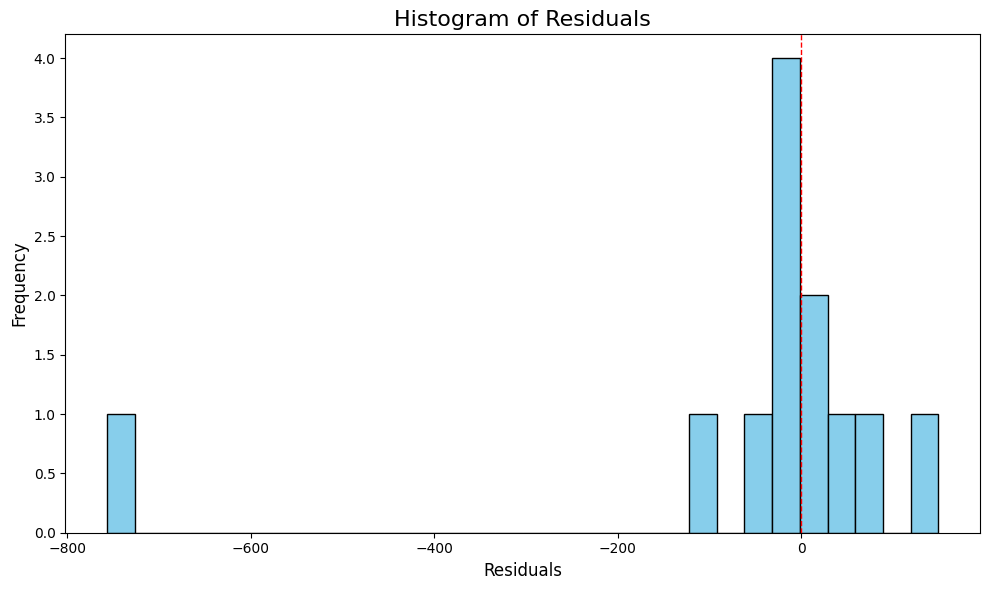

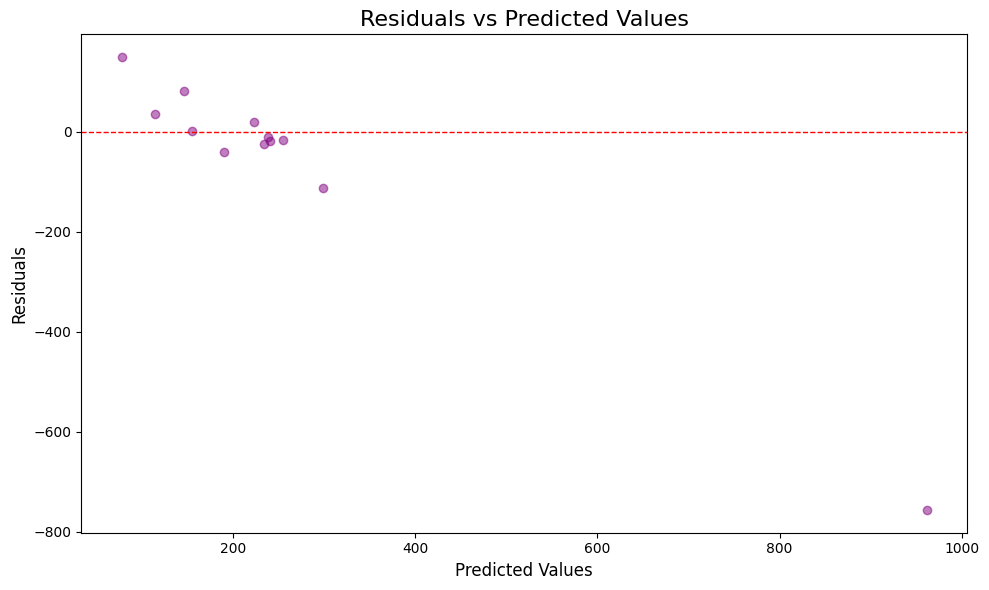

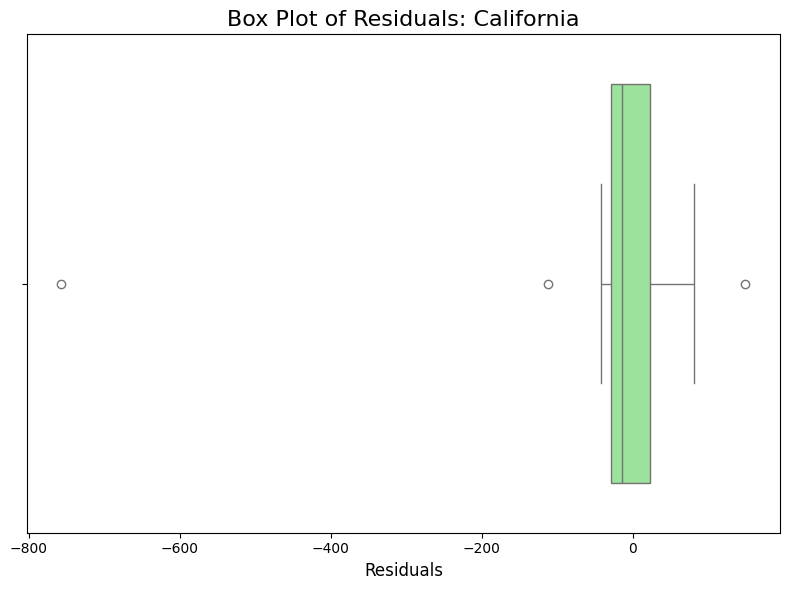

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = best_model.predict(X_test)
residuals = y_test - y_pred 
residuals = np.array(residuals).flatten()
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
plt.title("Histogram of Residuals", fontsize=16)
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='dashed', linewidth=1)
plt.title("Residuals vs Predicted Values", fontsize=16)
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x=residuals, color='lightgreen')
plt.title("Box Plot of Residuals: California", fontsize=16)
plt.xlabel("Residuals", fontsize=12)
plt.tight_layout()
plt.show()


In [29]:
from tensorflow.keras.models import load_model
import shap
import matplotlib.pyplot as plt

# Load the saved model
best_model = load_model('best_multi_target_model.h5', compile=False)
assert list(X_train.columns) == list(X_test.columns), "Mismatch in feature columns"


In [30]:
# Swapping PermutationExplainer for GradientExplainer
X_train_np = X_train.values
X_test_np = X_test.values   

explainer = shap.GradientExplainer(best_model, X_train_np)
shap_values = explainer.shap_values(X_test_np)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(12, 214))']
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 214))']
  warnings.warn(msg)


In [31]:
print(type(shap_values))
print(np.array(shap_values).shape)


<class 'numpy.ndarray'>
(12, 214, 1)


In [32]:
shap_values = np.squeeze(shap_values)  

import pandas as pd

feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

print("Feature importance:")
print(feature_importance)

Feature importance:
                                               feature  importance
117  Female_18_64yrs_Old_Population_Under_Poverty_A...    1.687941
85   Male_Population_In_Production_Transportation_A...    1.673174
130  Households_Received_Food_Stamps_In_The_Past_Ye...    1.650003
19   Population_16yrs_And_Over_Without_Earning_ACS2...    1.606940
34   Percent_Female_16yrs_And_Over_And_Above_In_Low...    1.469209
..                                                 ...         ...
92   Percent_Female_Population_In_Sales_And_Office_...    0.245740
17   Percent_Population_65yrs_And_Over_Without_Heal...    0.233230
0    Healthcare_General_Practice_Provider_Rate_per1...    0.225761
138  Percent_Population_5_17yrs_without_school_enro...    0.217720
213                                       state_number    0.000000

[214 rows x 2 columns]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


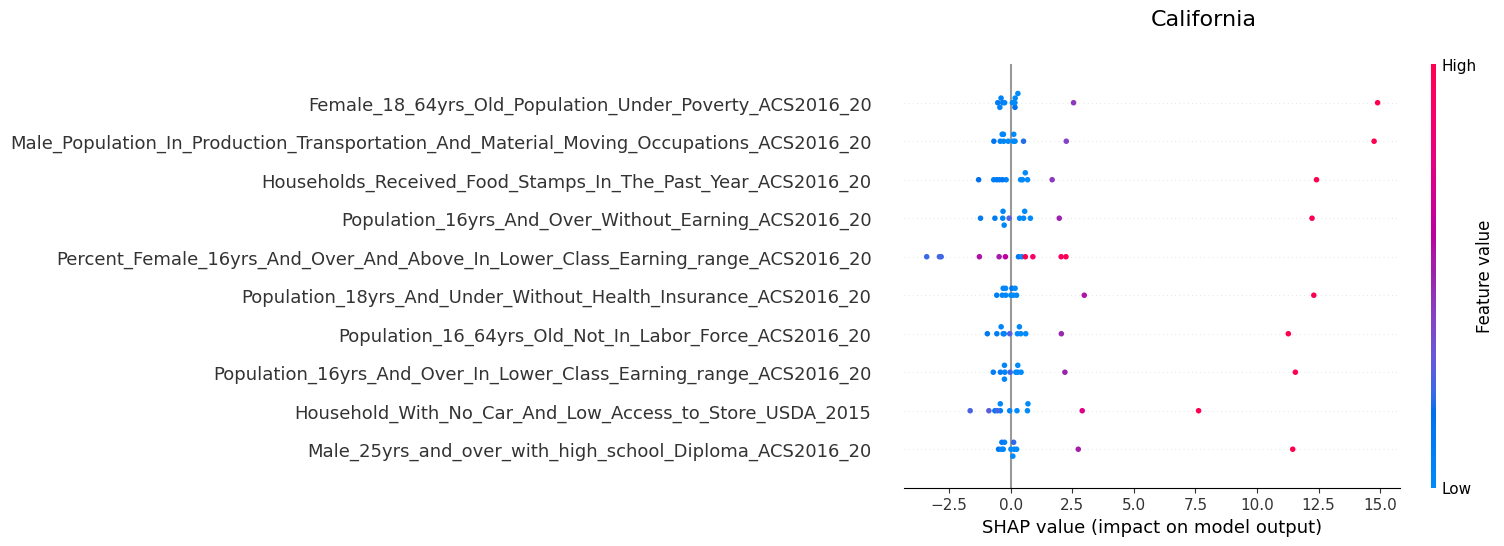

In [33]:
import shap
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X_test, max_display=10, show=False)
plt.gcf().suptitle("California", fontsize=16)
plt.show()

